In [1]:
import argparse
import datetime
import os,json
import pprint

import numpy as np
import torch, random
from torch.utils.tensorboard import SummaryWriter

import gymnasium as gym

from tianshou.data import Collector, ReplayBuffer, VectorReplayBuffer, NECSA_Collector
from tianshou.policy import RainbowPolicy, TD3Policy
from tianshou.trainer import offpolicy_trainer
from tianshou.exploration import GaussianNoise
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
from tianshou.utils.net.continuous import Actor, Critic
from tianshou.env import ShmemVectorEnv

In [2]:
torch.manual_seed(2023)
np.random.seed(2023)

In [3]:
def make_env(seed, task, training_num, test_num):
    env = gym.make(task)
    train_envs = ShmemVectorEnv(
        [lambda: gym.make(task) for _ in range(training_num)]
    )
    test_envs = ShmemVectorEnv([lambda: gym.make(task) for _ in range(test_num)])
    # env.seed(seed)
    train_envs.seed(seed)
    test_envs.seed(seed)
    
    return env, train_envs, test_envs

In [4]:
env, train_envs, test_envs = make_env(seed = 2023, task = "Walker2d-v4", training_num = 1, test_num = 1)

In [5]:
device = 'cpu'
hidden_sizes = [256, 256]
actor_lr = 3e-4
critic_lr = 3e-4
tau = 0.005
gamma = 0.99
update_actor_freq = 2
exploration_noise = 0.1
policy_noise = 0.2
noise_clip = 0.5
n_step = 1

#Collector
buffer_size = 10000
init_collection = 1

#NECSA
step = 1
grid_num = 5
epsilon = 0.2
mode = 'state'
reduction = False
state_dim = 16
state_min = -10
state_max = 10

In [6]:
state_shape = env.observation_space.shape or env.observation_space.n
action_shape = env.action_space.shape or env.action_space.n
max_action = env.action_space.high[0]
exploration_noise = exploration_noise * max_action
policy_noise = policy_noise * max_action
noise_clip = noise_clip * max_action

In [7]:
# model
net_a = Net(state_shape, hidden_sizes=hidden_sizes, device=device)
actor = Actor(
    net_a, action_shape, max_action=max_action, device=device
).to(device)
actor_optim = torch.optim.Adam(actor.parameters(), lr=actor_lr)
net_c1 = Net(
    state_shape,
    action_shape,
    hidden_sizes=hidden_sizes,
    concat=True,
    device=device,
)
net_c2 = Net(
    state_shape,
    action_shape,
    hidden_sizes=hidden_sizes,
    concat=True,
    device=device,
)
critic1 = Critic(net_c1, device=device).to(device)
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=critic_lr)
critic2 = Critic(net_c2, device=device).to(device)
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=critic_lr)

policy = TD3Policy(
    actor,
    actor_optim,
    critic1,
    critic1_optim,
    critic2,
    critic2_optim,
    tau=tau,
    gamma=gamma,
    exploration_noise=GaussianNoise(sigma=exploration_noise),
    policy_noise=policy_noise,
    update_actor_freq=update_actor_freq,
    noise_clip=noise_clip,
    estimation_step=n_step,
    action_space=env.action_space,

)


In [8]:
# collector
buffer = ReplayBuffer(buffer_size)

if not reduction:
    state_dim = env.observation_space.shape[0]

NECSA_DICT = {
    'step' : step,
    'grid_num' : grid_num,
    'epsilon' : epsilon,
    'mode' : mode,
    'reduction' : reduction,
    'raw_state_dim' : env.observation_space.shape[0],
    'state_dim' : state_dim,
    'state_min' : state_min,
    'state_max' : state_max,
    'action_dim' : env.action_space.shape[0],
    'action_min' : env.action_space.low[0],
    'action_max' : env.action_space.high[0]
}
print(NECSA_DICT)
train_collector = NECSA_Collector(policy, train_envs, buffer, NECSA_DICT = NECSA_DICT)
test_collector = Collector(policy, test_envs)
train_collector.collect(n_episode=1, random=True)

{'step': 1, 'grid_num': 5, 'epsilon': 0.2, 'mode': 'state', 'reduction': False, 'raw_state_dim': 17, 'state_dim': 17, 'state_min': -10, 'state_max': 10, 'action_dim': 6, 'action_min': -1.0, 'action_max': 1.0}


{'n/ep': 1,
 'n/st': 24,
 'rews': array([0.92576682]),
 'lens': array([24]),
 'idxs': array([0]),
 'rew': 0.9257668228060459,
 'len': 24.0,
 'rew_std': 0.0,
 'len_std': 0.0}

In [9]:
env.observation_space.sample()

array([-0.14372867,  0.04050651,  0.77793824,  0.93067389, -0.27839057,
        0.35365605, -0.05035106, -2.1263791 ,  0.49567315,  0.29141463,
        0.08668068,  0.78731289, -0.37730192,  1.65764302,  0.58552882,
        1.62266195,  0.28982003])

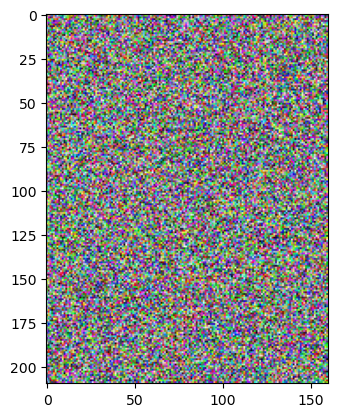

In [13]:
env.observation_space.sample()

(210, 160, 3)